In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import grad

from binarypredictor.datagen import PolyGenerator
from binarypredictor.poly import Polynomial, PolynomialSet
from binarypredictor.net import DerivativeNet

In [48]:
pg = PolyGenerator(2)
pg.add_constraint(0.5, 1, 0)
pg.add_constraint(0.1, 0, 1)
#pg.add_constraint(0.8, 0, 1)
pg.add_constraint(0.5, 0, 0)
#pg.add_constraint(0.9, 0, 5)
#pg.add_constraint(0.2, 0, 2.5)

qg = PolyGenerator(2)
qg.add_constraint(0.5, 1, 0)
qg.add_constraint(0.1, 0, 2)
qg.add_constraint(0.5, 0, -.2)
#qg.add_constraint(0.9, 1, -6)
#qg.add_constraint(0.9, 0, 8)
#qg.add_constraint(0.2, 0, 1.5)

In [49]:
x = torch.arange(0., 1.0, step=0.01)

poly_set = PolynomialSet() 
poly_set.append(Polynomial(pg.get_cfs())) 
poly_set.append(Polynomial(qg.get_cfs()))

d_poly_set = poly_set.get_derivatives()

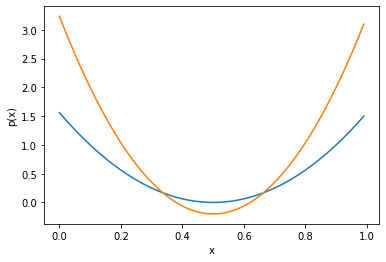

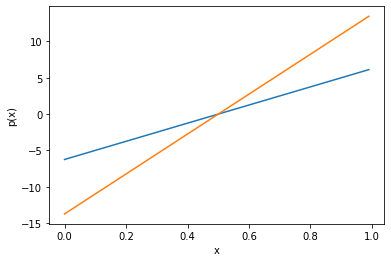

In [50]:
poly_set.plot(x)
plt.show()

d_poly_set.plot(x)
plt.show()

In [54]:
out_features = 100
lr = 1e-3

net_p = DerivativeNet(train=True, in_features=100, hidden_size_linear=256, out_features=out_features, hidden_layers=1)
net_q = DerivativeNet(train=True, in_features=100, hidden_size_linear=256, out_features=out_features, hidden_layers=1)
optimizer_p = torch.optim.Adam(net_p.parameters(), lr=lr)
optimizer_q = torch.optim.Adam(net_q.parameters(), lr=lr)

In [60]:
x_in = torch.arange(0., 1.0, step=0.01)
x = torch.arange(0., 1., step=1/out_features)

for i in range(20000):
    inp = poly_set.get_values(x_in, 'h')
    out_p = net_p(inp[:, 0].squeeze().float())
    out_q = net_q(inp[:, 1].squeeze().float())
    
    x_range = torch.vstack((out_p, out_q)).T
    p_vals = poly_set.get_values(x_range)
    dp_vals = d_poly_set.get_values(x_range, o=1)
        
    optimizer_p.zero_grad(), optimizer_q.zero_grad()
    loss = nn.MSELoss()(p_vals[:,0] - out_p * dp_vals[:, 0], p_vals[:,1] - out_q * dp_vals[:, 1])
    loss.backward(retain_graph=True)
    optimizer_p.step()
    optimizer_q.step()
    
    if i % 250 == 0:
        print(loss)

tensor(284.5702, grad_fn=<MseLossBackward0>)
tensor(7.7949e-11, grad_fn=<MseLossBackward0>)
tensor(1.9458e-13, grad_fn=<MseLossBackward0>)


KeyboardInterrupt: 

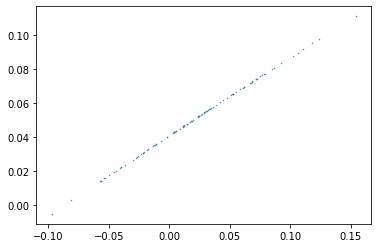

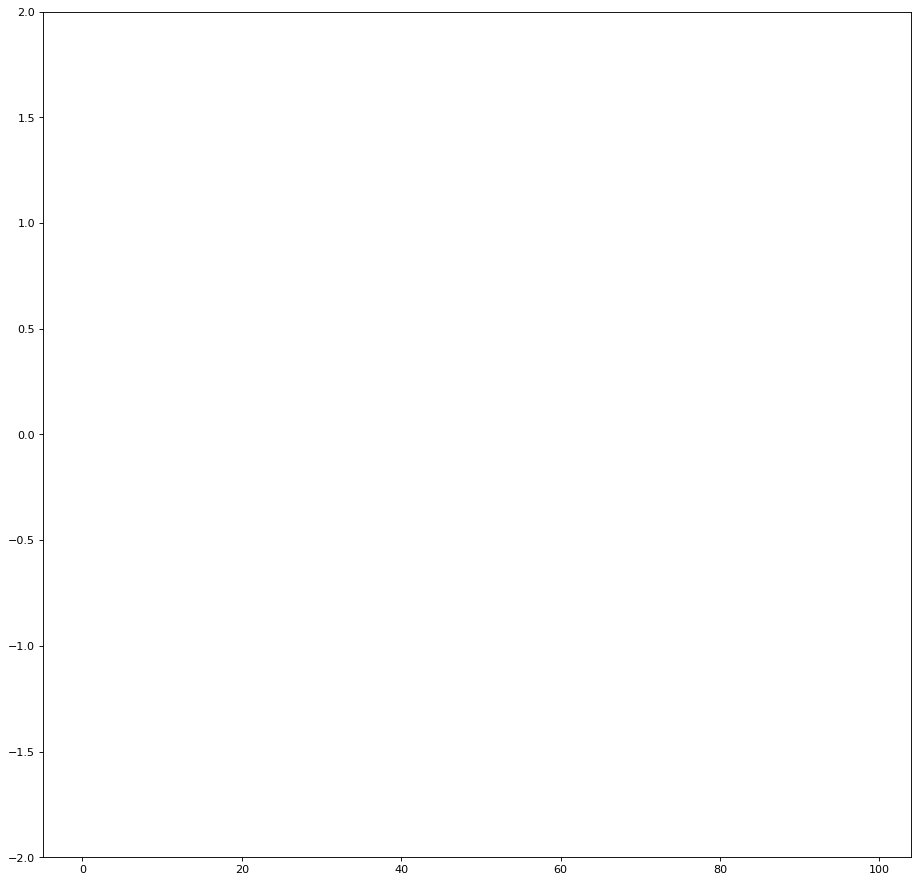

In [61]:
out_p = (net_p(inp[:, 0].squeeze().float()))
out_q = (net_q(inp[:, 1].squeeze().float()))

plt.scatter(out_p.detach(), out_q.detach(), s=0.2)
plt.show()

x_range = torch.vstack((out_p, out_q)).T

dp_vals = d_poly_set.get_values(x_range)
plt.figure(figsize=(14, 14), dpi=80)
plt.scatter(range(len(out_p)), dp_vals[:, 0].detach(), s=2)
plt.scatter(range(len(out_q)), dp_vals[:, 1].detach(), s=2)
plt.scatter(range(len(out_q)), (dp_vals[:, 0] - dp_vals[:, 1]).detach(), s=2)
plt.ylim(-2, 2)
plt.show()

In [62]:
idx = torch.where(abs(dp_vals[:, 0] - dp_vals[:, 1]) < 1e-1)
print(idx)
print(dp_vals[idx])

(tensor([], dtype=torch.int64),)
tensor([], size=(0, 2), grad_fn=<IndexBackward0>)


tensor([], size=(0, 2), grad_fn=<IndexBackward0>)



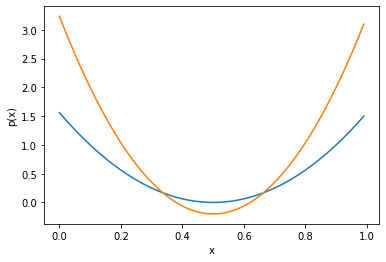

In [63]:
if len(idx) > 0:
    
    xpq = x_range[idx]
    print(xpq)
    
    xp, xq = xpq[:, 0], xpq[:, 1]

    print(*zip(xp.detach().numpy(), xq.detach().numpy()))
    y = poly_set.get_values(xpq)
    poly_set.plot(x)
    plt.plot([xp.detach().numpy(), xq.detach().numpy()], [y[:, 0].detach().numpy(), y[:, 1].detach().numpy()], marker='o')
    plt.show()
    
    for xp_, xq_, y_ in zip(xp, xq, y):
        poly_set.plot(x)
        plt.plot([xp_.detach().numpy(), xq_.detach().numpy()], [y_[0].detach().numpy(), y_[1].detach().numpy()], marker='o')
        plt.show()
else:
    print('No common tangents!')

In [59]:
print(eqn_poly_set_.get_values(xpq))
print(d_poly_set.get_values(xpq))

tensor([[-3.5548, 14.4619]], grad_fn=<CatBackward0>)
tensor([[-2.7299, -2.8236]], grad_fn=<CatBackward0>)


In [ ]:
ccc = torch.tensor([4, 2, 1])
ccc_ = (ccc * torch.flip(torch.arange(len(ccc)), dims=(-1,)))[:-1]

print(ccc_)